# Normalized Batch vs No Normalization

This notebook contains a comparison between using batch normalization and not using it when training a CNN.

## Setup

In [12]:
# Importing the Libraries

%matplotlib inline
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

import pdb
from itertools import product
torch.set_printoptions(linewidth=300)

In [13]:
# Setting the ipython display
ipython = 'inline' in matplotlib.get_backend()
if ipython: from IPython import display

In [14]:
# Initializing the device
device = device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [15]:
# Loading the training set
train_set = torchvision.datasets.FashionMNIST(
    root='./data'
    ,train=True
    ,download=True
    ,transform=transforms.Compose([
        transforms.ToTensor()
    ])
)

In [17]:
# Network Architecture (with batch normalization)
class NetworkBN(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 12, 5),         # (N, 1, 28, 28) -> (N,  12, 24, 24)
            nn.BatchNorm2d(12),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),  # (N, 12, 24, 24) -> (N,  12, 12, 12)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(12, 24, 5),        # (N, 12, 12, 12) -> (N,  24, 8, 8)
            nn.BatchNorm2d(24),         
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2)   # (N, 24, 8, 8) -> (N,  24, 4, 4)
            )
        self.fc = nn.Sequential(
            nn.Linear(384, 120),         
            nn.ReLU(),
            nn.Linear(120,10)
        )

    def forward(self, t):

        t = self.conv1(t)
        t = self.conv2(t)
        t = t.reshape(-1, 384)
        t = self.fc(t)

        return t

In [18]:
# Network Architecture (without batch normalization)
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 12, 5),         # (N, 1, 28, 28) -> (N,  12, 24, 24)
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),  # (N, 12, 24, 24) -> (N,  12, 12, 12)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(12, 24, 5),        # (N, 12, 12, 12) -> (N,  24, 8, 8)
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2)   # (N, 24, 8, 8) -> (N,  24, 4, 4)
            )
        self.fc = nn.Sequential(
            nn.Linear(384, 120),         
            nn.ReLU(),
            nn.Linear(120,10)
        )

    def forward(self, t):

        t = self.conv1(t)
        t = self.conv2(t)
        t = t.reshape(-1, 384)
        t = self.fc(t)

        return t

In [19]:
# Function to get the number of correct predictions
def num_correct(preds,labels):
    return preds.argmax(dim=1).eq(labels).nonzero(as_tuple=True)[0].numel()

In [71]:
# Plotting function
def show_loss(train_losses,train_corrects,train_losses_bn,train_corrects_bn,ep):
    fig, axs = plt.subplots(1,2)
    plt.subplots_adjust(right=2)
    axs[0].plot(train_losses)
    axs[0].plot(train_losses_bn)
    axs[0].set_ylabel('Loss')
    axs[0].set_xlabel('Epoch')

    axs[1].plot([c / len(train_set) for c in train_corrects], label='No normalization')
    axs[1].plot([cbn / len(train_set) for cbn in train_corrects_bn], label='Normalized batch')
    axs[1].legend(loc="lower right")
    axs[1].set_ylabel('Accuracy')
    axs[1].set_xlabel('Epoch')

    plt.pause(0.001)

    if ipython: display.clear_output(wait=True)

## Training the Network

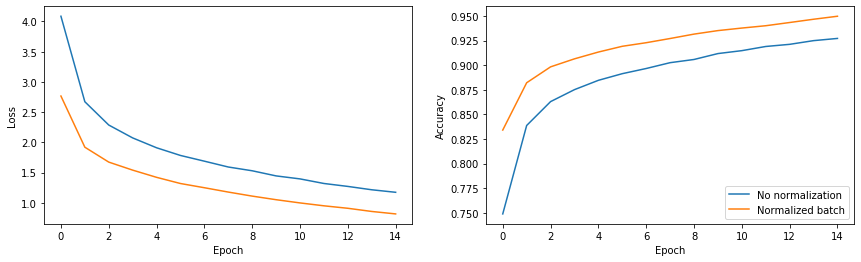

In [73]:
net = Network().to(device)
netbn = NetworkBN().to(device)

train_loader = torch.utils.data.DataLoader(train_set
,batch_size=100
,shuffle=True
)

optimizer = optim.Adam(params=net.parameters(), lr=0.001)
optimizerbn = optim.Adam(params=netbn.parameters(), lr=0.001)

# Lists of training results
train_losses = []
train_corrects = []
train_losses_bn = []
train_corrects_bn = []


# Training Loop
for e in range(15):
    train_loss = 0
    total_train_correct = 0
    train_loss_bn = 0
    total_train_correct_bn = 0

    # No batch normalization iteration
    for batch in train_loader:
        images, labels = batch
        images = images.to(device)
        labels = labels.to(device)
        preds = net(images)

        loss = F.cross_entropy(preds, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item() / 100
        total_train_correct += num_correct(preds,labels)
    
    # Normalized batch iteration
    for batch in train_loader:
        images, labels = batch
        images = images.to(device)
        labels = labels.to(device)
        preds = netbn(images)

        loss = F.cross_entropy(preds, labels)
        optimizerbn.zero_grad()
        loss.backward()
        optimizerbn.step()
        train_loss_bn += loss.item() / 100
        total_train_correct_bn += num_correct(preds,labels)
    
    train_losses.append(train_loss)
    train_corrects.append(total_train_correct)
    train_losses_bn.append(train_loss_bn)
    train_corrects_bn.append(total_train_correct_bn)

    
    show_loss(train_losses,train_corrects,train_losses_bn,train_corrects_bn,e)

#### Saving the model

In [ ]:
# torch.save(net.state_dict(), 'model.pt')

#### Loading the model

In [1]:
# net = Network().to(device)
# net.load_state_dict(torch.load('model.pt'))
# net.eval()